## Lecture 5

#### Announcements

* Final Project vs. Final Exam
  * The class overwhelmingly prefers a final project
  * It will be proposal-based
  * We'll start picking topics and writing proposals in week 6 (after Spring break)
  * The project will be group-optional
* Project 1 is out.
  * Very soon: make sure you can pull and run the starting code!
* Feedback on week 2 HW



#### Goals
* Know what is meant by **local image features**.
* Understand the motivation for **detecting**, **describing**, and **matching** local image **features**.
* Understand why **uniqueness** and **invariance** are desirable properties of features and their descriptors.
* Know how to detect corner features using the Harris corner detector.

In [1]:
# boilerplate setup
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
import sys

src_path = os.path.abspath("../src")
if (src_path not in sys.path):
    sys.path.insert(0, src_path)

# Library imports
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import skimage as skim
import cv2

# codebase imports
import util
import filtering

#### Plan
* Brief slides - (recap) setup for feature matching
* Which points should we try to match, and how should we describe them?
* Uniqueness and invariance
* Arrive at: corner features, local uniqueness; address invariance with the descriptor
* Corner finding: whiteboard discussion; error function visualization demo; whiteboard --> eigenvalues
* Decode the structure tensor: how do we compute it? Convolution!
* Implement features.harris_score
* Play with that on some images
* Implement non-max suppression via maximum filter

What makes good features?

* Uniqueness: features **shouldn't** match if they're from different points in the scene.  
* Invariance: features **should** match if they do come from the same point in the scene. 

##### Homework Problem 1

In terms of uniqueness and invariance, discuss why arbitrary single pixels, described using their RGB values, would not make good features for image matching.

What might be a *little* bit better?

Idea: patches. Is it perfect?

![](../data/fences.jpg)

No! But it's hard to imageine something that is. Let's settle for this and talk about how to find patches that will be **locally** unique.

#### Question: what sorts of points will be matchable from one image to another? 

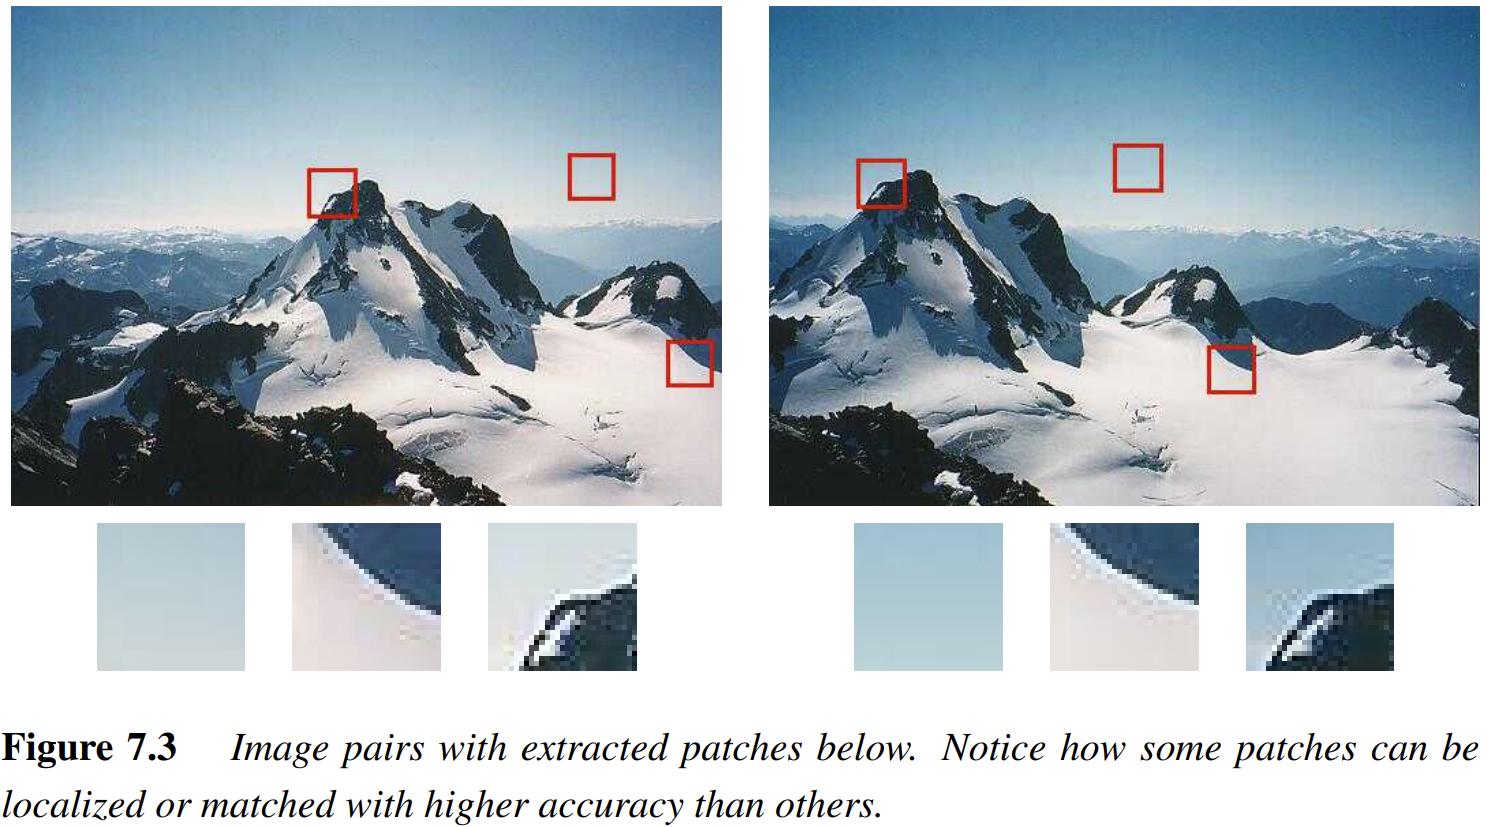
(Source: Szeleski 2ed. Figure 7.3)

#### Whiteboard: Harris Corner Detection

Here are the rough notes I used for the whiteboard presentation.

##### Idea: the thing that goes wrong:
1. If I shift my patch a little distance in some direction, and it looks almost the same, that's bad.
2. It doesn't have to look the same in all directions. If there's even one direction where the pathc looks the same after a shift then that's a failure case.
3. Can we measure the "shiftability" of a patch?

##### Attempt 1 at a solution
Hey how much something changes in a direction... this sounds like a gradient magnitude!

* Right angle example - this seems like it's going to work!
* Diagonal line example - darn. This isn't going to work.

##### Attempt 2 at a solution
Throw out the gradient idea and brute force it: compare a patch to all its neighbors. 

Let's call our point of interest $(x^*, y^*)$. Choose a window $W$ around that point. Do the usual thing: $W$ is square, and it's width/height is an odd number $L$, and it's centered on $(x^*, y^*)$. Describe the window as a set of pixels $(x,y) \in W$.

* Evaluate a particular shift $(u,v)$ and compute a distance.
  * $E(u, v) = \sum_{x, y \in W} \left[ I(x+u, y+v) - I(x, y) \right]^2$​​​
  * For each pixel (x, y) in the window, compare the pixel at (u,v) offset from (x, y) to the un-offset (x, y)

**Q**: Suppose we did that, and distance measurements from many offset windows. How would you turn that into a single "shiftableness" score?

**A**: The **minimum** distance would work - a small minimum distance is a shiftable patch, and a large minimum distance means this should be a matchable patch.

##### Attempt 3 at a solution (this one works!)

Okay but this is really expensive.
* **for** each candidate match point $(x^*, y^*)$,
  * **for** each offset $(u,v)$
    * **for** each pixel $(x,y)$ in the patch around $(x^*, y^*)$
      * sqaure / add stuff up

**Idea:** Appoximate the offset error function $E(u,v)$

Taylor expansion reminder:
$$
f(x) = f(a) + f'(a)(x-a) + f''(a)(x-a)^2 + \ldots
$$
For a first-order (linear) Taylor approximation,
$$
f(x) \approx f(a) + f'(a)(x-a)
$$


In our bivariate context:
$$
I(x+u, y+v) \approx I(x, y) 
+ \frac{\partial{I}}{\partial x} u 
+ \frac{\partial{I}}{\partial y} v
$$
Look, the derivatives came back!

Plug this into our "error" function:
$$
\begin{align}
E(u, v) &= \sum_{x, y \in W} \left[  I(x+u, y+v) - I(x, y) \right]^2\\
&\approx \sum_{x, y \in W} \left[
	I(x, y) + \frac{\partial{I}}{\partial x} u
  							+ \frac{\partial{I}}{\partial y} v -  I(x, y))\right]^2\\
&\approx \sum_{x, y \in W} \left[
								  \frac{\partial{I}}{\partial x} u
                + \frac{\partial{I}}{\partial y} v\right]^2
\end{align}
$$

**Pause** At this point, it's fair to ask what the heck we're looking at.


In [7]:
# You don't have this yet, sorry! 
# It's a homework question
from features import visualize_harris

%matplotlib widget

h = imageio.imread("../data/harris_crop.jpg")
h = skim.color.rgb2gray(h.astype(np.float32) / 255)

hfull = imageio.imread("../data/harris.jpg")
hfull = filtering.down_2x(skim.color.rgb2gray(hfull.astype(np.float32) / 255))

Here's a visualization of the error function $E(u, v)$ as we shift a patch around in a real image.
* Top left: the original image with the patch highlighted
* Top right: the actual error computed by shifting that patch to each position in a (by defualt 13x13) windo.
* Bottom left: the approximate error function computed by substituting the linearized approximation based on the derivatives.
* Bottom right: a contour plot of the same data as the bottom left.

Notice tha the top right and bottom left are 3D plots, so you can drag them to change views.

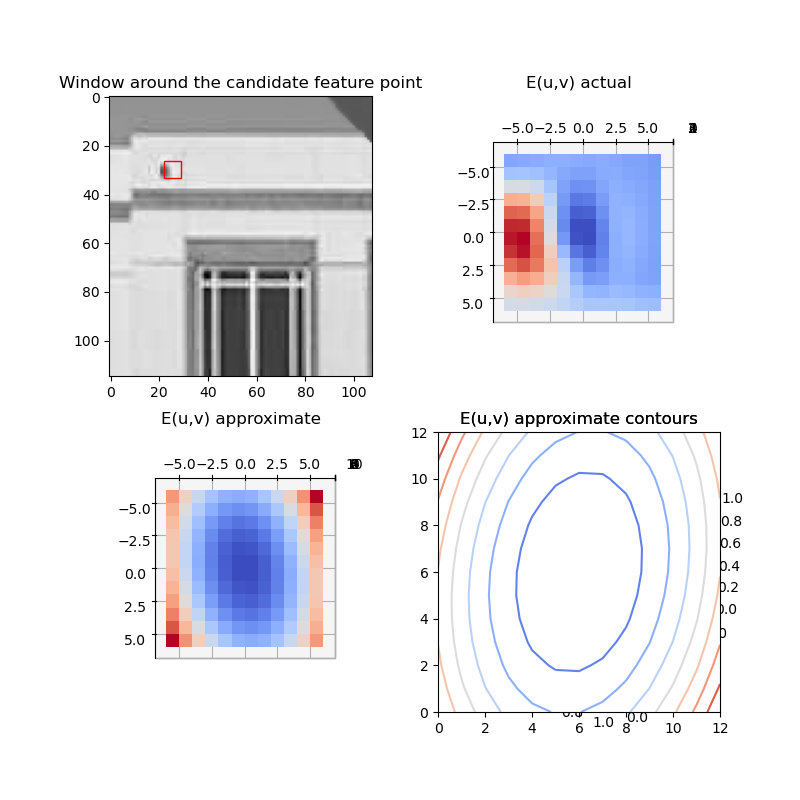

In [10]:
# try:
visualize_harris(h, 59, 85)
# visualize_harris(h, 30, 60)
# visualize_harris(h, 72, 60)
# visualize_harris(h, 30, 26)

##### Homework Problem 2

Play around with this visualization and answer the following:

For each of the following (linearized) error function shapes, describe the image patch that gave rise to it:

1. Flat in all directions
2. Steep in one direction, flat in the orthogonal direction
3. Steep in all directions

The linearized error function is now a 2D quadratic! We can see that depending on the image patch content, its shape varies in steepness in different directions. What we're after is points whose error is steep in all directions: these are least likely to be confused with their neighbors, or in other words, corner-like!

Okay, onward with the math that will tell us about steepness-in-different-directions!

Let's make some shorthand. Let:
$$
I_x = \frac{\partial{I}}{\partial x}
$$
$$
I_y = \frac{\partial{I}}{\partial y}
$$

So now we have:
$$
E(u, v) \approx \sum_{x, y \in W} \left[ I_xu + I_yv \right]^2
$$
FOIL!
$$
E(\mathbf{u}) \approx \sum_{\mathbf{x} \in W} \left[ I_x^2u^2 + 2I_xI_yuv + I_y^2v^2 \right]
$$
Now rewrite this as a matrix-vector product:
$$
E(u, v) \approx
\sum_{\mathbf{x} \in W} \left(
\begin{bmatrix} u & v \end{bmatrix}
\begin{bmatrix}
I_x^2  & I_xI_y \\
I_xI_y &  I_y^2 \\
\end{bmatrix}
\begin{bmatrix} u \\ v \end{bmatrix}
\right)
$$
Pull the sums into the matrix:

$$
E(u, v) \approx
\begin{bmatrix} u & v \end{bmatrix}
\begin{bmatrix}
\sum I_x^2  & \sum I_xI_y \\
\sum I_xI_y & \sum I_y^2 \\
\end{bmatrix}
\begin{bmatrix} u \\ v \end{bmatrix}
$$
This matrix is called the **structure tensor**, and it gives us a compact way to measure corneriness.

**Aside**: Long ago, we acknowledged that looking at gradient magnitudes seemed like a good idea, but a simple "both must be large" rule (e.g, by multiplying the two together) didn't get us what we needed because this was true for diagonal lines. At this point we're going to use some more math to arrive at a different way to combine the gradients that **is** only large when the feature is corner-like. The specifics of the math are here so you know where the formula comes from, but that's the heart of it - just a fancier way to combine gradients to tell when it's truly cornery.

The error function we get after the linear approximation always represents a 2D quadratic (see the visualization examples in the notebook). That quadratic could be:
* very wide and shallow (which happens for flat patches in the image)
* wide in one direction but steep in the orthogonal direction (which happens for patches that lie on edges)
* steep in all directions (which happens for corner patches)

It turns out that the **eigenvectors and eigenvalues** of the structure tensor matrix above can tell us which of these cases we're in! You may recall that an eigenvector/eigenvalue pair is a vector $v$ and a scalar $\lambda$ such that $Av = \lambda v$. There's a geometric interpretation in which the eigenvectors and eigenvalues determine the major and minor axes of an ellipse:

![](../data/harris_ellipse.jpg)

Here, the ellipse traces out a line of constant value in the error function $E(u, v)$. The direction of the major and minor axes are determined by the eigenvectors ($\mathbf{v}_1$ and $\mathbf{v}_2$), while their lengths are inversely proportional to the (square root of) the eigenvalues. A small eigenvalue makes for a longer axis, while a larger eigenvalue makes for a shorter axis - in other words, you have to go less far to get a given amount of error.

If corners are points where the error goes up really fast, then a good metric for corneriness is the size of the *smaller* eigenvalue. If both eigenvalues are large, then there is no direction you can move for very long while maintaining small error, or in other words, the patch cannot be confused with its neighbors in any direction. If either eigenvalue is small, then you can move in the direction of its eigenvector and maintain low error.

#### Computing it

We're interested in the eigenvalues of the structure tensor matrix:

$$
\begin{bmatrix}
\sum I_x^2  & \sum I_xI_y \\
\sum I_xI_y & \sum I_y^2 \\
\end{bmatrix}
$$
How do we actually compute this? 

Recall that the summations $\left(\sum\right)$  are over all pixels in a window around the pixel in question. That sounds familiar... we can do this with convolution!

Here's an approach that accomplishes this for every pixel in an image, all in one go:

* Calculate gradients with sobel filters

* From this, compute three images representing $I_x^2$,  $I_xI_y$, and $I_y^2$

* Why? It works better?

* Call those three blurred images $A, B, C$; we now have the elements of the matrix
  $$
  \begin{bmatrix}
  A  & B \\
   B & C \\
  \end{bmatrix}
  $$
  for every pixel in the image! 

* Calculate its eigenvalues (I just looked up the formula):

  * Let $d = AC - BB$​
  * Let $t = \frac{A+C}{2}$
  * $ \lambda_1, \lambda_2 = t \pm \sqrt{t^2 - d}$

* The smaller of these two at each pixel will be the Harris score!

##### Homework Problem 6

Write psudeocode (or working Python code if you like, based on our lecture repository codebase) for Harris scores (i.e., smallest eigenvalue of the structure tensor for each pixel). You should make (exact or pseudocody) use of filtering and other routines that already exist in the lecture codebase.

If you want to try it out, work in `features.py` and test it out with the code below!

In [ ]:
%matplotlib inline

import features

img = h # hfull

threshold = 0.3

plt.figure(figsize=(10, 5))
scores = features.harris_score(img)
plt.imshow(scores)
plt.colorbar()

Next steps: thresholding and non-maximum suppression

In [ ]:
# threshold
plt.imshow(scores > threshold)

Non-Maximum Suppression:
1. Apply maximum filter
2. Keep only pixels that are equal to the max-filtered image

In [ ]:
scores_maxfilter = filtering.maximum_filter(scores, 7)
features_mask = np.logical_and(scores > threshold, scores == scores_maxfilter)
plt.figure(figsize=(10, 10))
plt.imshow(features.overlay_features(img, features_mask))

In [ ]:
# putting it all together:

def harris(img, threshold):
    scores = features.harris_score(img)
    scores_maxfilter = filtering.maximum_filter(scores, 7)
    features_mask = np.logical_and(scores > threshold, scores == scores_maxfilter)
    plt.figure(figsize=(10, 10))
    plt.imshow(features.overlay_features(img, features_mask))

In [ ]:
harris(h, 0.1)